In [1]:
"""""from interaction_matrices import interactions
from decay_matrices import decay_class
from rho_X import rho
import Lambdas
"""""

'""from interaction_matrices import interactions\nfrom decay_matrices import decay_class\nfrom rho_X import rho\nimport Lambdas\n'

In [1]:
import Lambdas_i_ms
from differential_i_ms import Solver

In [2]:
from scipy.integrate import odeint
from scipy.interpolate import UnivariateSpline
from scipy.integrate import solve_ivp
from scipy.sparse import *
import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import json
from jupyterthemes import jtplot


# MCEq Imports
from MCEq.particlemanager import ParticleManager
import MCEq.core 
from MCEq.core import MCEqRun
from MCEq.data import Decays
import mceq_config as config
#import primary model choices
import crflux.models as pm



config.debug_level = 0





In [3]:

# In[ ]:
Name=[r"$P^{+}$",
          r"$\overline{P}^{-}$",
          r"$n^0$",
          r"$\overline{n}$",
          r"$\pi^{+}$",
          r"$\pi^{-}$",
          r"$K_{S}^0$"
          ,r"$K_{L}^0$",
          r"$K^{+}$",
          r"$K^{-}$",
          r"$\pi^{0}$",
          r"$\Lambda_{r}^{0}$",
          r'$\Lambda^{0}$',
          r"$\mu^{-}$",
          r"$\mu^{+}$",
          r"$e^{+}$",
          r"$e^{-}$",
          r"$\nu_{e}$",
          r"$\overline{\nu}_{e}$",
          r"$\nu_{\mu}$"
          ,r"$\overline{\nu}_{\mu}$" ,
          r'$\gamma$'

    ]



In [4]:
import codecs
file = codecs.open('/home/kruteesh/Desktop/Solar_neutrinos/rho.txt', 'r', 'UTF-8')
print(file)
tline = file.readlines()
b=tline[5:]
r_ratio=[]
rho_data=[]
c=[]
for i in b:
    r_ratio.append(float(i.split(' ')[1]))

    rho_data.append(float(i.split(' ')[3]))

"The Sun and the X for the path from sun "
R_sun=6.957e10
h_list=[0.8]

new_h=np.array([h*R_sun for h in h_list])
print(new_h)
"""""
x2rho={}
final_X={}#the dictionaries
for h in new_h:
    rhh=rho(R_sun,h,r_ratio,rho_data)
    x2rho[h]=rhh.X2rho()
    final_X[h]=rhh.final_X()
  
    
# In[34]:

"""""

[5.5656e+10]


'""\nx2rho={}\nfinal_X={}#the dictionaries\nfor h in new_h:\n    rhh=rho(R_sun,h,r_ratio,rho_data)\n    x2rho[h]=rhh.X2rho()\n    final_X[h]=rhh.final_X()\n  \n    \n# In[34]:\n\n'

In [5]:
 mceq_run= MCEqRun(
    #provide the string of the interaction model
    interaction_model="SIBYLL23CPP",
    #primary cosmic ray flux model
    primary_model = (pm.HillasGaisser2012, "H3a"),
    
    # Zenith angle in degrees. 0=vertical, 90=horizontal
    theta_deg=0.0
    
    )
I_models=["EPOSLHC","QGSJETII04","SIBYLL23C03"]
r={}

In [6]:
for i_m in I_models:
    mceq_run.set_interaction_model(i_m)
    # Launcing mceq
    print(mceq_run.pman[2212].cs[-1])
    list_particles=[mceq_run.pman[2212],     #p+           (0)
                    mceq_run.pman[-2212],     #pbar-        (1)
                    mceq_run.pman[2112],     #n            (2)
                    mceq_run.pman[-2112],    #nbar         (3)
                    mceq_run.pman[211],      #pi+          (4)
                    mceq_run.pman[-211],     #pi-          (5)
                    mceq_run.pman[310],      #K_S0         (6) 
                    mceq_run.pman[130],      #K_L0         (7)
                    mceq_run.pman[321],      #K+           (8)
                    mceq_run.pman[-321],     #K-           (9)
                    mceq_run.pman[111],      #pi0          (10)
                    mceq_run.pman[-3122],    #Lambdbar0    (11)
                    mceq_run.pman[3122],     #Lambda0      (12)
                    mceq_run.pman[13],   #mu-          (13)
                    mceq_run.pman[-13],  #mu+          (14)
                    mceq_run.pman[-11],      #e+           (15)   
                    mceq_run.pman[11],       #e-           (16)
                    mceq_run.pman[12],       #nue         (23)
                    mceq_run.pman[-12],      #nuebar      (24)
                    mceq_run.pman[14],       #numu         (21)
                    mceq_run.pman[-14],      #numubar       (22)
                    mceq_run.pman[22]#gamma        (25)
                   ]

    jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
    """""
    For indices of the particles in phi 
    """""
    j=0
    ind={}
    for i in list_particles:
        ind[i.name,'up']=0+j
        ind[i.name,'low']=121+j
        j=j+121


    """""
    The primary fluxes
    """""
    phi=np.zeros(len(list_particles)*121)
    phi0_p = (
        mceq_run._phi0[mceq_run.pman[2212].lidx:mceq_run.pman[2212].uidx]
    )
    phi0_n=(
        mceq_run._phi0[mceq_run.pman[2112].lidx:mceq_run.pman[2112].uidx]
    )
    phi[242:363]=phi0_n
    phi[0:121]=phi0_p


    # In[31]:


    phi0_mu=mceq_run.e_grid**(-2)
    phi_test=np.zeros(len(list_particles)*121)
    phi_test[ind["mu+","up"]:ind["mu+","low"]]=phi0_mu


    #list of pdg ids 
    list_particles_pdg_id=[]
    for i in range(0,len(list_particles)):
        list_particles_pdg_id.append(list_particles[i].pdg_id[0])



    
    r[i_m]=Solver(i_m,list_particles,R_sun,new_h,phi).solver(r_ratio,rho_data)

6.251988150598832e-25
S6.251988150598832e-25


/home/kruteesh/Desktop/Solar_neutrinos/diffsec/the_python_files/Untitled Folder/interaction_matrices.py:184: RuntimeWarning: divide by zero encountered in true_divide
  rescaling = np.nan_to_num(particle.inel_cross_section(mbarn=False) / total_xsec_tmp)
/home/kruteesh/Desktop/Solar_neutrinos/diffsec/the_python_files/Untitled Folder/interaction_matrices.py:184: RuntimeWarning: invalid value encountered in true_divide
  rescaling = np.nan_to_num(particle.inel_cross_section(mbarn=False) / total_xsec_tmp)
/home/kruteesh/Desktop/Solar_neutrinos/diffsec/the_python_files/Untitled Folder/decay_matrices.py:61: RuntimeWarning: divide by zero encountered in true_divide
  c = np.divide(a, b)
/home/kruteesh/Desktop/Solar_neutrinos/diffsec/the_python_files/Untitled Folder/decay_matrices.py:61: RuntimeWarning: invalid value encountered in true_divide
  c = np.divide(a, b)


6.251988150598832e-25
55656000000.0
4626.029349088669
5.725806291835406e-25
S5.725806291835406e-25
5.725806291835406e-25
55656000000.0
4162.185930013657
5.845941370755435e-25
S5.845941370755435e-25
5.845941370755435e-25
55656000000.0
4822.6093690395355


In [7]:
pickle.dump(r,open("03,02,21_i_ms.pkl","wb"))


In [8]:
r[I_models[0]].keys()

dict_keys([55656000000.0])

In [9]:
X,x2rho=Solver(I_models,list_particles,R_sun,new_h,phi).X_rho(r_ratio,rho_data)

6957000000.0
48699000000.0


In [22]:
6957000000.0/R_sun

0.1

In [11]:

# In[33]:


#plt.figure(figsize=(11,11))
small_list=[
                #mceq_run.pman[(13,0)],
                mceq_run.pman[-13],
    #mceq_run.pman[11],
    mceq_run.pman[-11],
                #mceq_run.pman[211],       #numu        (21)
                #mceq_run.pman[130],
                #mceq_run.pman[321],
                #mceq_run.pman[(-13,0)],  #mu+          (14)
                #mceq_run.pman[211],      #pi+          (4)
               # mceq_run.pman[-211],     #pi-          (5)
               # mceq_run.pman[111], #pi0          (10)
                #mceq_run.pman[14],       #nue          (21)
                mceq_run.pman[-14],      #antinue       (22)
                #mceq_run.pman[12],       #numu         (23)
                mceq_run.pman[-12]      #antinumu      (24) 
    
]
ls=['r--','g--','k--','c--','b--','y--','r-.','g-.','k-.','c-.','b-.','y-.','r-','g-','b-','c-','k-'
    ,'y-','r.','g.','k.','y.','c.','b.'
   ]

In [18]:
r[I_models[0]][0.7*R_sun][-1].shape


(2662,)

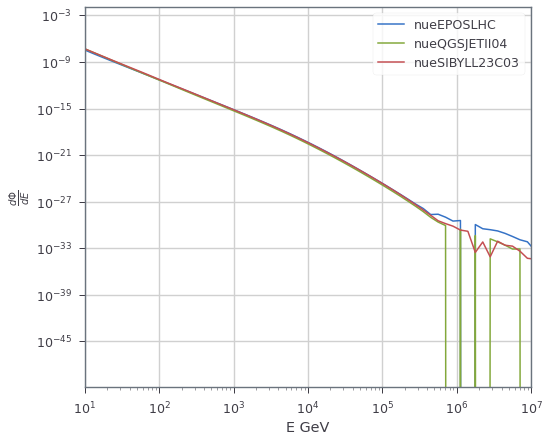

In [21]:
p=mceq_run.pman[12]
for i,im in enumerate(I_models):
    
   
    bb_1=(r[im][0.7*R_sun])
         
       # bb_2=np.transpose(sol_ivp_csr[h_list[i+1]*R_sun]['y'])
        #phi_ratio=bb_1[-1][ind[p.name,'up']:ind[p.name,'low']]/ bb_2[-1][ind[p.name,'up']:ind[p.name,'low']]
    rr=(bb_1[-1][ind[p.name,'up']:ind[p.name,'low']])
    #print(rr)  
        #rr=rr*(mceq_run.e_grid**3)
    plt.plot(mceq_run.e_grid,rr,label=p.name+' '+im)
    #print(np.sum(rr*mceq_run.e_widths,axis=0))
    #phi_t.append(abs(np.sum(rr*mceq_run.e_widths,axis=0)))   

#plt.scatter(h_list[::-1],
                 #phi_t[::-1],label=p.name)
        
   # plt.plot(mceq_run.e_grid,phi[ind["p+","up"]:ind["p+","low"]],"c-.",label="p+ initial ")

    #plt.title(r" max X =  "+ '{:e}'.format(X[new_h[i]][-1]))
plt.xlabel("E GeV")
plt.ylabel(r'$\frac{d\Phi}{dE}$')
        #plt.ylim((1e-85,1e3))
plt.xlim((1e1,1e7))
plt.legend()
plt.grid()
plt.xscale("log")
plt.yscale("log")
   # plt.savefig('/home/kruteesh/Desktop/Solar_neutrinos/diffsec/pics/16,01,21/'+str(h_list[i])+'.png')


# In[48]:




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
phi_t=[]
p=mceq_run.pman[14]
for im in I_models:
    bb_1=(r[im][0].T)
    rr=(bb_1[-1][ind[p.name,'up']:ind[p.name,'low']])
    print(np.sum(rr*mceq_run.e_widths))
    phi_t.append(abs(np.sum(rr*mceq_run.e_widths)))

fig, ax = plt.subplots()
hh=h_list[::-1]
ax.scatter(,phi_t,label=p.name)
#ax.set_xlim(5, 0)  # decreasing time
#ax.set_yscale("log")
ax.set_xlabel("h/R")
ax.set_ylabel(r"$\Phi$")
ax.grid(True)
ax.legend()
plt.show()

In [ ]:
h_list[::-1]

In [ ]:
plt.plot(r_ratio,rho_data)
plt.xlabel("R/R_sun")
plt.ylabel(r"$\rho_{sun}$   g/$cm^3$")
#plt.ylim((140,160))
#plt.xlim((-0.005,0.02))